## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import time
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
import tensorflow as tf
import pandas as pd

In [3]:
from library.datasets.cifar10 import CIFAR10
from library.plot_tools import plot
from library.utils import file_utils
from library.tf.models.mlp_classifier import MLPClassifier

## Select Tensorflow device

In [4]:
# from tensorflow.python.client import device_lib
# local_device_protos = device_lib.list_local_devices()
# cpu_devices = [x.name for x in local_device_protos if x.device_type == 'CPU']
# gpu_devices = [x.name for x in local_device_protos if x.device_type == 'GPU']
# print('Available CPU Devices: ', end='')
# print(cpu_devices)
# print('Available GPU Devices: ', end='')
# print(gpu_devices)
# if len(gpu_devices) == 0:
#     if len(cpu_devices) > 0:
#         device_name = '/cpu:0'
#         print('Using CPU: %s' %device_name)
#     else:
#         print('No CPU present in the system!!!')
# else:
#     device_name = '/gpu:0'
#     print('Using GPU: %s' %device_name)

In [5]:
total_time = 0

## Experiment

In [6]:
exp_no = 1
data_source = 'Website'
num_images_required = 1.0
file_no = 103

### Parameters for experiment

In [7]:
device_name = '/gpu:0'
learn_rate = 0.01
batch_size = 200
train_epochs = 200
display_step = 1
reg_const = 0.01
train_val_split_data = None
train_val_split = 0.8
transform = True
transform_method = 'StandardScaler'
learn_rate_type = 'constant'
dataset = 'cifar10'
descent_method = 'adam'

### Log directories

In [8]:
log_dir = '../logs/' + dataset + '/' + str(file_no).zfill(3) + '_tf_mlp_raw/exp_no_' + str(exp_no).zfill(3) + '/'
log_file = log_dir + 'mlp_classifier.ckpt'
model_file = log_dir + 'mlp_classifier.pb'
print('Writing tensorboard logs to %s' % log_file)
print('View logs by running tensorboard: ', end='')
print('\"tensorboard --logdir=\'./%s/103_tf_mlp_raw/\' --port 61111\"' %dataset)

Writing tensorboard logs to ../logs/cifar10/103_tf_mlp_raw/exp_no_001/mlp_classifier.ckpt
View logs by running tensorboard: "tensorboard --logdir='./cifar10/103_tf_mlp_raw/' --port 61111"


## Step 1: Load CIFAR 10 Dataset

In [9]:
start = time.time()
one_hot = True
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required, preprocess='StandardScaler',
                  train_validate_split=train_val_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 1] Loaded CIFAR 10 Dataset in %.4f ms' %((end-start)*1000))
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 50000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5


/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 6.8878 seconds
[ Step 1] Loaded CIFAR 10 Dataset in 6889.1959 ms


In [10]:
print('Train data shape:', cifar10.train.data.shape)
if one_hot is True:
    print('Train labels shape:', cifar10.train.one_hot_labels.shape)
print('Train class labels shape:', cifar10.train.class_labels.shape)
if train_val_split_data is not None:
    print('Validate data shape:', cifar10.validate.data.shape)
    if one_hot is True:
        print('Validate labels shape:', cifar10.validate.one_hot_labels.shape)
    print('Validate class labels shape:', cifar10.validate.class_labels.shape)
print('Test data shape:', cifar10.test.data.shape)
if one_hot is True:
    print('Test labels shape:', cifar10.test.one_hot_labels.shape)
print('Test class labels shape:', cifar10.test.class_labels.shape)

Train data shape: (50000, 3072)
Train labels shape: (50000, 10)
Train class labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000, 10)
Test class labels shape: (10000,)


In [11]:
print('Training images')
print(cifar10.train.data[:5])
if one_hot is True:
    print('Training labels')
    print(cifar10.train.one_hot_labels[:5])
print('Training classes')
print(cifar10.train.class_labels[:5])
print('Testing images')
print(cifar10.test.data[:5])
if one_hot is True:
    print('Testing labels')
    print(cifar10.test.one_hot_labels[:5])
print('Testing classes')
print(cifar10.test.class_labels[:5])

Training images
[[-0.977 -1.203 -1.122 ...,  0.403 -0.459 -0.641]
 [ 0.317 -0.057 -0.361 ...,  0.388  0.431  0.448]
 [ 1.693  1.696  1.688 ..., -0.475 -0.474 -0.46 ]
 [-1.399 -1.286 -1.288 ..., -1.323 -1.179 -1.035]
 [ 0.535  0.523  0.636 ..., -0.491 -0.551 -0.52 ]]
Training labels
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
Training classes
[6 9 9 4 1]
Testing images
[[ 0.375  0.401  0.468 ...,  0.142  0.219 -0.081]
 [ 1.425  1.395  1.395 ...,  0.98   1.174  1.274]
 [ 0.375  0.387  0.109 ..., -1.658 -1.722 -1.65 ]
 [ 0.334  0.511  0.621 ..., -1.006 -0.967 -0.995]
 [-0.894 -0.829 -1.15  ...,  0.328  0.481  0.025]]
Testing labels
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  

## Step 1.1 Load sample images

Plotting CIFAR 10 Train Dataset


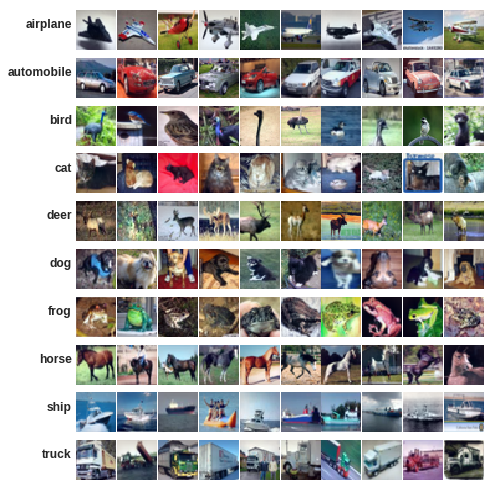

Plotting CIFAR 10 Test Dataset


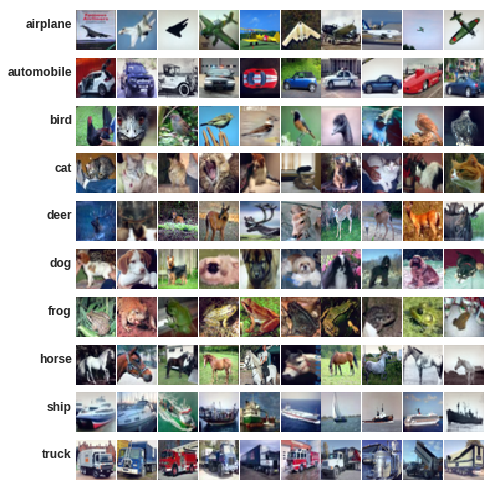

In [12]:
cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

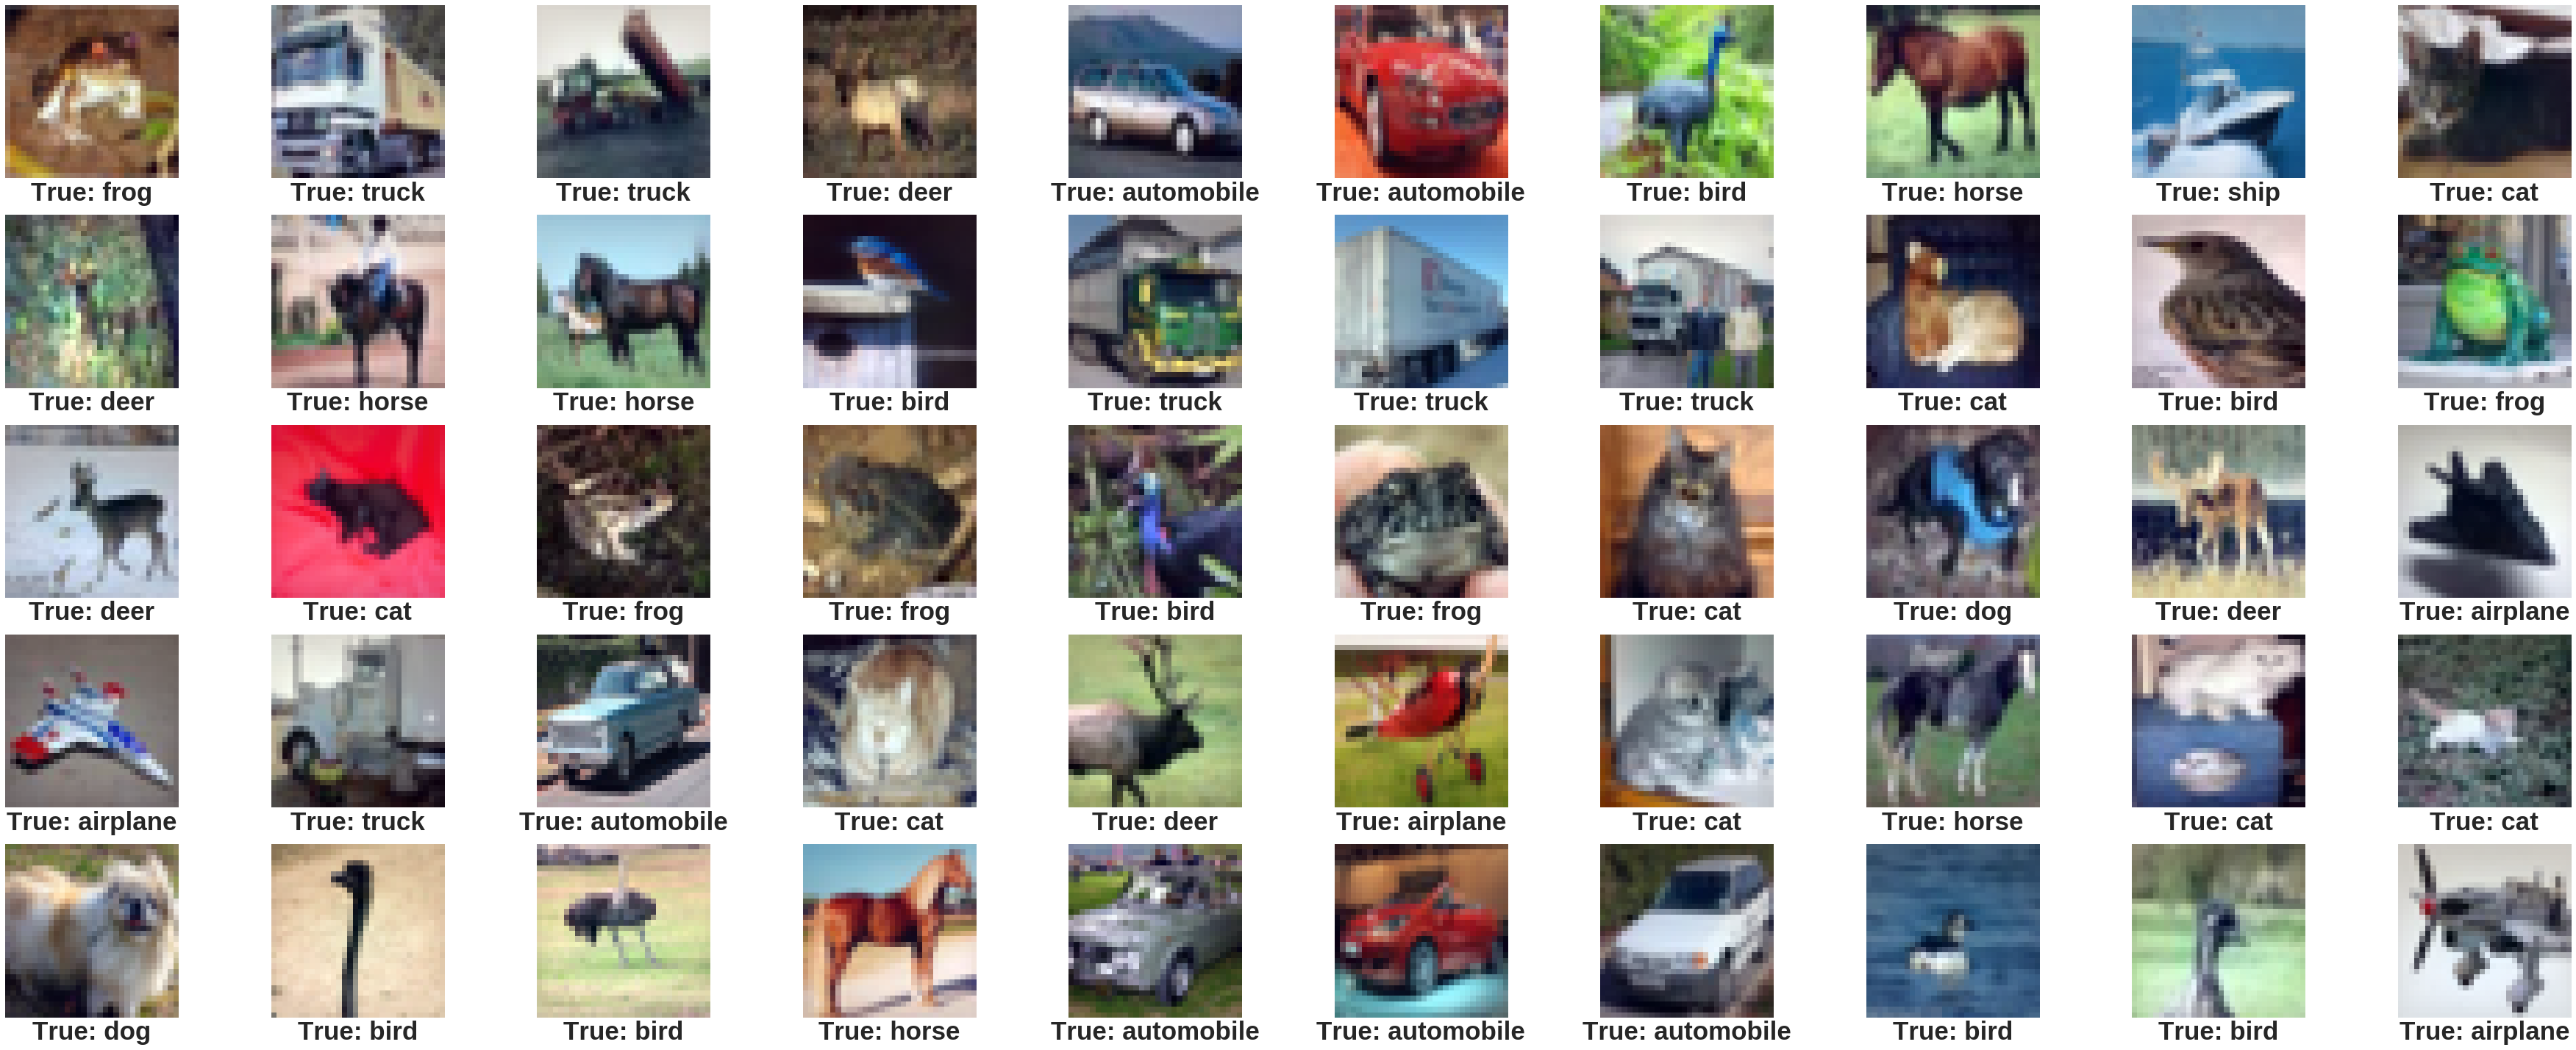

True

In [13]:
cifar10.plot_images(cifar10.train.data[:50, :], cifar10.train.class_names[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

## Step 2: Multilayer Perceptron Classifier

In [14]:
num_features = cifar10.train.data.shape[1]
num_classes = 10

In [15]:
network_config = {'layer_1': {'weight': {'name': 'Weight_1', 'type': 'random_normal'},
                              'bias': {'name': 'Bias_1', 'type': 'zeros'},
                              'activation_fn': 'relu',
                              'num_nodes': 3072,
                              'layer_name': 'Layer_1'
                              },
                  'layer_2': {'weight': {'name': 'Weight_2', 'type': 'random_normal'},
                              'bias': {'name': 'Bias_2', 'type': 'zeros'},
                              'activation_fn': 'relu',
                              'num_nodes': 3072,
                              'layer_name': 'Layer_2'
                              },
                  'output_layer': {'weight': {'name': 'Output_Weight', 'type': 'random_normal'},
                                   'bias': {'name': 'Output_Bias', 'type': 'zeros'},
                                   'activation_fn': 'relu',
                                   'layer_name': 'Output_Layer'
                                  }
                 }

In [16]:
mlp = MLPClassifier(verbose=False, device=device_name, session_type='interactive', num_iter=train_epochs, 
                    err_tolerance=1e-7, train_validate_split=train_val_split, display_step=display_step,
                    learn_step=10, learn_rate_type=learn_rate_type, learn_rate=learn_rate, reg_const=reg_const, 
                    logs=True, log_dir=log_dir, test_log=True, save_model=True, checkpoint_filename=log_file, 
                    save_checkpoint=True, restore=False, model_name=model_file, config=network_config,
                    batch_size=batch_size)

### Step 2.2: Create the tensorflow graph

In [17]:
start = time.time()
mlp.create_graph(num_features=num_features, num_classes=num_classes)
end = time.time()
print('Generated the tensorflow graph in %.4f ms' %((end-start)*1000))
total_time = (end-start)

Session: <tensorflow.python.client.session.InteractiveSession object at 0x7fe5adb8c3c8>
Model has been trained for 0 iterations
Tensorflow graph created in 1.5293 seconds
Generated the tensorflow graph in 1530.3838 ms


In [18]:
mlp.print_parameters()

Parameters for MLP classifier
>> Input Parameters
Input                  : Tensor("Inputs/Data/X_input:0", shape=(?, 3072), dtype=float32, device=/device:GPU:0) 
True one hot labels    : Tensor("Inputs/Train_Labels/y_true_one_hot_label:0", shape=(?, 10), dtype=float32, device=/device:GPU:0) 
True class             : Tensor("Inputs/Train_Labels/y_true_class:0", shape=(?,), dtype=int64, device=/device:GPU:0) 
Predict one hot labels : Tensor("Predictions/one_hot:0", shape=(?, 10), dtype=float32, device=/device:GPU:0) 
Predict class          : Tensor("Predictions/predict_class:0", shape=(?,), dtype=int64, device=/device:GPU:0) 
>> Layer 1
	Weights : Tensor("Parameters/Weights/Weight_1/read:0", shape=(3072, 3072), dtype=float32, device=/device:GPU:0)
	Bias    : Tensor("Parameters/Bias/Bias_1/read:0", shape=(3072,), dtype=float32, device=/device:GPU:0)
	Layer   : Tensor("Hidden_Layers/Layer_1_1:0", shape=(?, 3072), dtype=float32, device=/device:GPU:0)
>> Layer 2
	Weights : Tensor("Parameters

### Step 2.3: Fit the model/training

In [19]:
start = time.time()
mlp.fit(cifar10.train.data, cifar10.train.one_hot_labels, cifar10.train.class_labels,
        test_data=cifar10.test.data, test_labels=cifar10.test.one_hot_labels, test_classes=cifar10.test.class_labels)
end = time.time()
print('Fit completed in %.4f seconds' % (end-start))

Length of train loss          : 0
Length of train accuracy      : 0
Length of validate loss       : 0
Length of validate accuracy   : 0
Length of test accuracy       : 0
Restoring training from epoch : 0
>>> Epoch [  0/200]
train_loss: 1.6872 | train_acc: 0.3600 | val_loss: 1.6753 | val_acc: 0.4105 | test_acc: 0.4151 | Time: 6.0933 s
>>> Epoch [  1/200]
train_loss: 1.5800 | train_acc: 0.4050 | val_loss: 1.5845 | val_acc: 0.4489 | test_acc: 0.4417 | Time: 5.5492 s
>>> Epoch [  2/200]
train_loss: 1.4984 | train_acc: 0.4600 | val_loss: 1.5359 | val_acc: 0.4690 | test_acc: 0.4574 | Time: 5.6366 s
>>> Epoch [  3/200]
train_loss: 1.4287 | train_acc: 0.4750 | val_loss: 1.5007 | val_acc: 0.4803 | test_acc: 0.4704 | Time: 5.7342 s
>>> Epoch [  4/200]
train_loss: 1.3661 | train_acc: 0.5150 | val_loss: 1.4743 | val_acc: 0.4881 | test_acc: 0.4792 | Time: 5.7115 s
>>> Epoch [  5/200]
train_loss: 1.3102 | train_acc: 0.5400 | val_loss: 1.4537 | val_acc: 0.4951 | test_acc: 0.4851 | Time: 5.6880 s
>>> 

### Step 2.4: Make the predictions

In [20]:
prediction_numbers = mlp.predict(cifar10.test.data)
prediction_classes = []
num_test_images = cifar10.test.data.shape[0]
for i in range(num_test_images):
    prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])

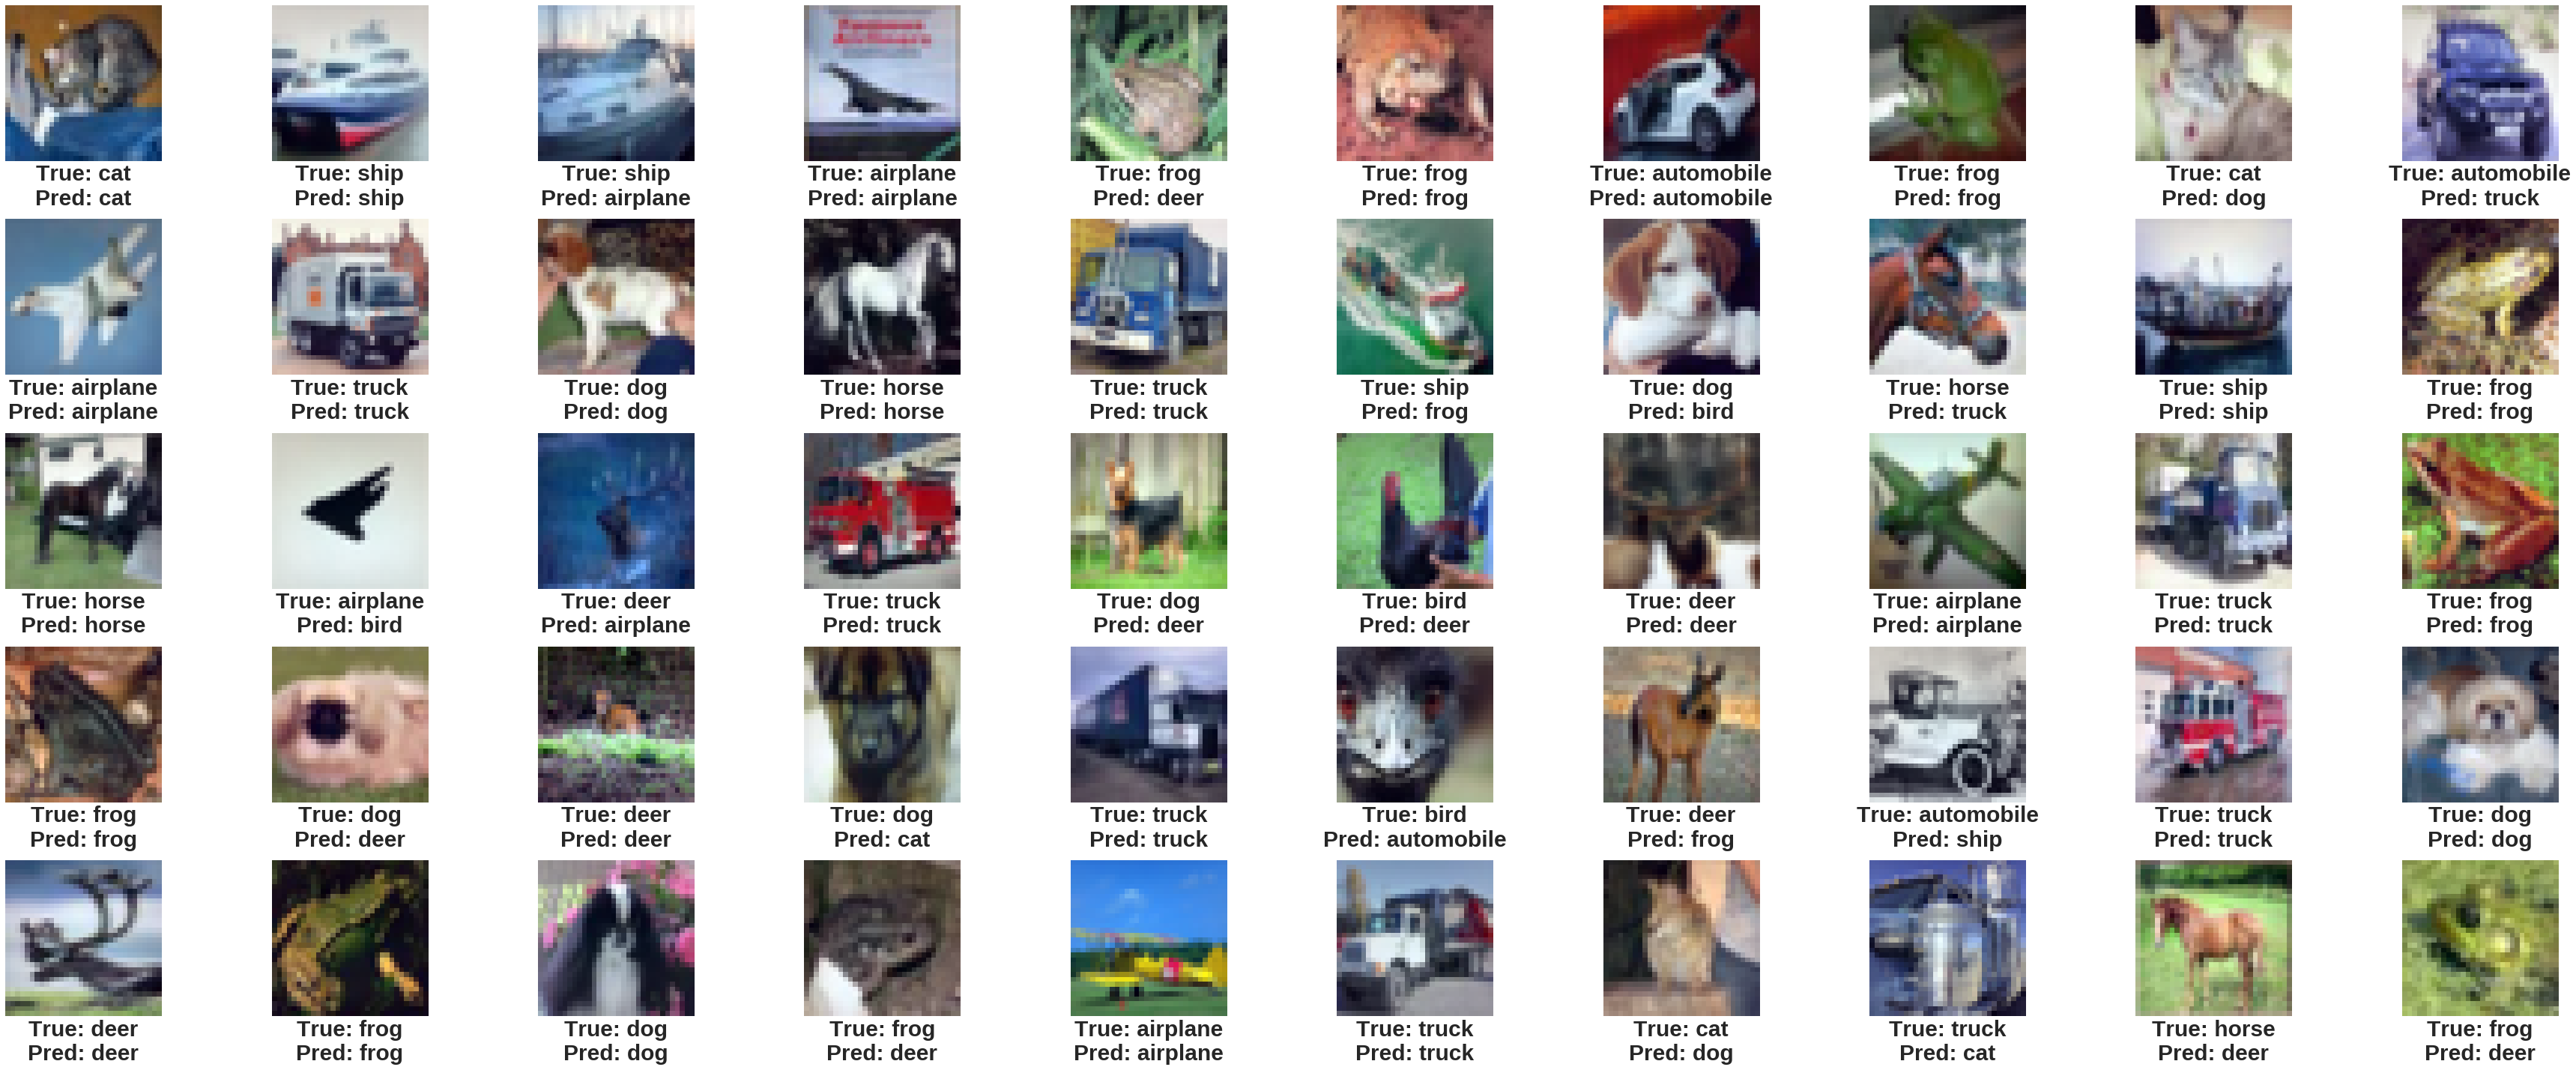

True

In [21]:
cifar10.plot_images(cifar10.test.data[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=30, convert=True)

### Step 2.5: Print the results

In [22]:
test_accuracy = mlp.score(cifar10.test.data, cifar10.test.class_labels)
print('Accuracy of the linear classifier on test dataset: %.4f' %test_accuracy)

Accuracy of the linear classifier on test dataset: 0.5413


Confusion matrix, without normalization
[[631  26  65  14  34  21  25  25 102  57]
 [ 43 628  22  24  17  11  25  18  62 150]
 [ 73  18 443  77 122  88  94  57  13  15]
 [ 27  11 113 336  75 193 124  61  18  42]
 [ 45  13 140  47 467  60  88  96  24  20]
 [ 13   8  88 188  78 441  68  74  17  25]
 [ 13  23 101  82  84  47 597  23  12  18]
 [ 34  16  65  63  85  68  19 603   9  38]
 [ 76  58  26  30  24  24  11   5 689  57]
 [ 50 143  17  34  18  25  23  47  65 578]]
Normalized confusion matrix
[[ 0.631  0.026  0.065  0.014  0.034  0.021  0.025  0.025  0.102  0.057]
 [ 0.043  0.628  0.022  0.024  0.017  0.011  0.025  0.018  0.062  0.15 ]
 [ 0.073  0.018  0.443  0.077  0.122  0.088  0.094  0.057  0.013  0.015]
 [ 0.027  0.011  0.113  0.336  0.075  0.193  0.124  0.061  0.018  0.042]
 [ 0.045  0.013  0.14   0.047  0.467  0.06   0.088  0.096  0.024  0.02 ]
 [ 0.013  0.008  0.088  0.188  0.078  0.441  0.068  0.074  0.017  0.025]
 [ 0.013  0.023  0.101  0.082  0.084  0.047  0.597  0.023  0.01

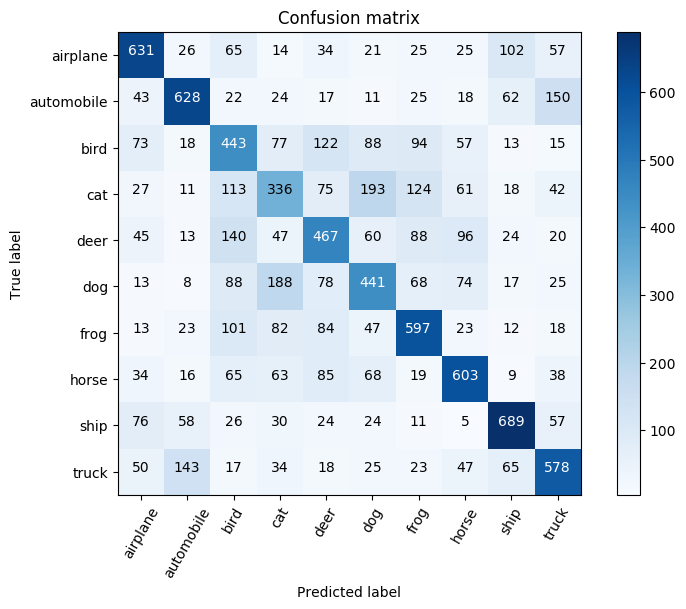

Detailed classification report
             precision    recall  f1-score   support

   airplane       0.63      0.63      0.63      1000
 automobile       0.67      0.63      0.65      1000
       bird       0.41      0.44      0.43      1000
        cat       0.38      0.34      0.35      1000
       deer       0.47      0.47      0.47      1000
        dog       0.45      0.44      0.45      1000
       frog       0.56      0.60      0.58      1000
      horse       0.60      0.60      0.60      1000
       ship       0.68      0.69      0.69      1000
      truck       0.58      0.58      0.58      1000

avg / total       0.54      0.54      0.54     10000



In [23]:
mlp.print_classification_results(cifar10.test.data, cifar10.test.one_hot_labels, cifar10.test.class_labels,
                                 test_class_names=cifar10.classes, normalize=True)

### Step 2.6: Plot results

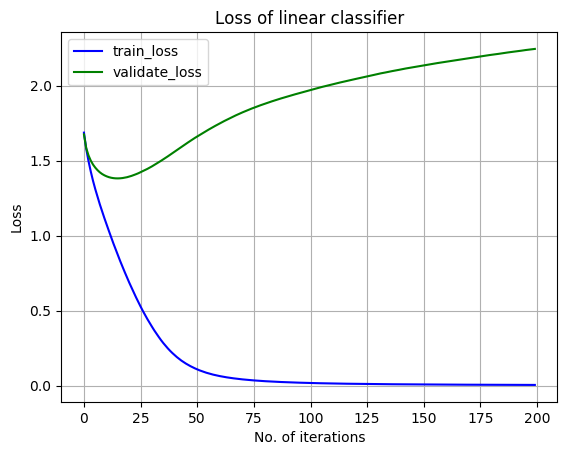

True

In [24]:
mlp.plot_loss()

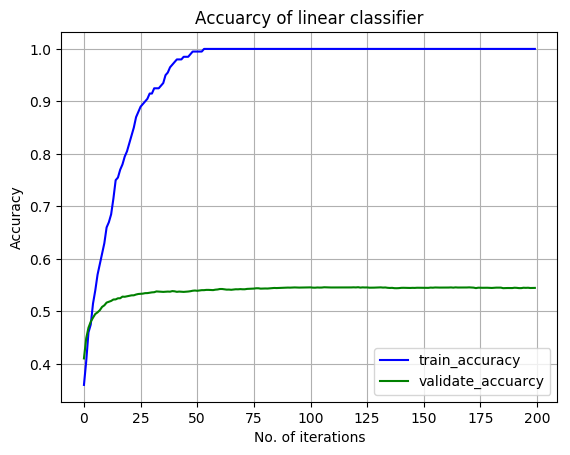

True

In [25]:
mlp.plot_accuracy()

### Step 2.7: Close the session

In [26]:
mlp.close()

## Step 3: Write predictions to CSV

In [27]:
start = time.time()
indices = np.arange(1, cifar10.test.data.shape[0]+1)
predictions = np.column_stack((indices, prediction_classes))
file_utils.mkdir_p(log_dir)
output_csv_file = log_dir + '103_' + 'mlp' + '.csv'
column_names = ['id', 'label']
predict_test_df = pd.DataFrame(data=predictions, columns=column_names)
predict_test_df.to_csv(output_csv_file, index=False)
end = time.time()
print('[ Step 11] Writing the test data to file: %s in %.6f ms' %(output_csv_file, (end-start)*1000))
total_time += (end-start)

[ Step 11] Writing the test data to file: ../logs/cifar10/103_tf_mlp_raw/exp_no_001/103_mlp.csv in 139.714479 ms


## Step 4: Write to file

In [28]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [29]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

<IPython.core.display.Javascript object>

In [32]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [33]:
current_file = './' + theNotebook + '.ipynb'
output_file = log_dir + str(file_no).zfill(3) + '_exp_no_' + str(exp_no).zfill(3) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(log_dir) 
output_HTML(current_file, output_file)

Current file: ./103_Tf_MLP_Classifier_Raw_features_CIFAR_10.ipynb
Output file: ../logs/cifar10/103_tf_mlp_raw/exp_no_001/103_exp_no_001_103_Tf_MLP_Classifier_Raw_features_CIFAR_10.html

